# OSDA: Lazy FCA

## 0. Import

In [61]:
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

warnings.simplefilter("ignore", FutureWarning)

## 1. Load Dataset

In [2]:
df = pd.read_csv("adult.csv")
df.shape

(32561, 15)

In [3]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df["income"].value_counts()

income
<=50K    24720
>50K      7841
Name: count, dtype: int64

## 2. Stratified 1000 Sample

In [5]:
df = df.replace("?", pd.NA).dropna()
df.shape

(30162, 15)

In [6]:
df_sub = df.groupby("income", group_keys=False).apply(lambda x: x.sample(
    n=int(round(1000 * len(x) / len(df))), random_state=42
)).sample(n=1000, random_state=42)

df_sub.shape

(1000, 15)

In [7]:
X = df_sub.drop(columns=["income"])
y = df_sub["income"].map({">50K": 1, "<=50K": 0})

y.value_counts(normalize=True)

income
0    0.751
1    0.249
Name: proportion, dtype: float64

## 3. EDA

In [8]:
counts_income = df["income"].value_counts().sort_index()
labels_income = counts_income.index.astype(str)
values_income = counts_income.values
props_income = values_income / values_income.sum()
counts_income

income
<=50K    22654
>50K      7508
Name: count, dtype: int64

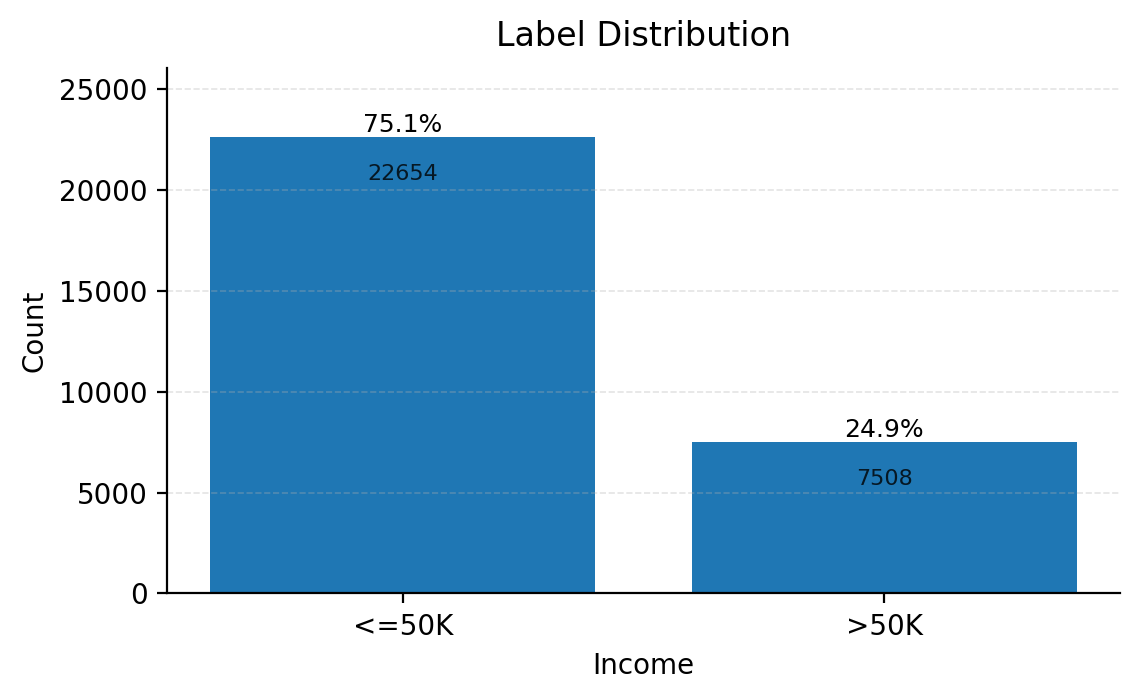

In [9]:
plt.figure(figsize=(5.8, 3.6), dpi=200)
ax = plt.gca()
bars = ax.bar(labels_income, values_income)

ax.set_title("Label Distribution", fontsize=12, pad=8)
ax.set_xlabel("Income", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.35)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ymax = values_income.max()
ax.set_ylim(0, ymax * 1.15)

for b, v, p in zip(bars, values_income, props_income):
    ax.text(b.get_x() + b.get_width()/2, v, f"{p:.1%}", ha="center", va="bottom", fontsize=9)
    ax.text(b.get_x() + b.get_width()/2, v - ymax*0.06, f"{v}", ha="center", va="top", fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

In [10]:
num_cols_eda = ["age", "hours.per.week", "capital.gain", "capital.loss"]
df_num = df[num_cols_eda + ["income"]].copy()
df_num["income_bin"] = df_num["income"].map({">50K": 1, "<=50K": 0})
df_num.head()

,age,hours.per.week,capital.gain,capital.loss,income,income_bin
1,82,18,0,4356,<=50K,0
3,54,40,0,3900,<=50K,0
4,41,40,0,3900,<=50K,0
5,34,45,0,3770,<=50K,0
6,38,40,0,3770,<=50K,0


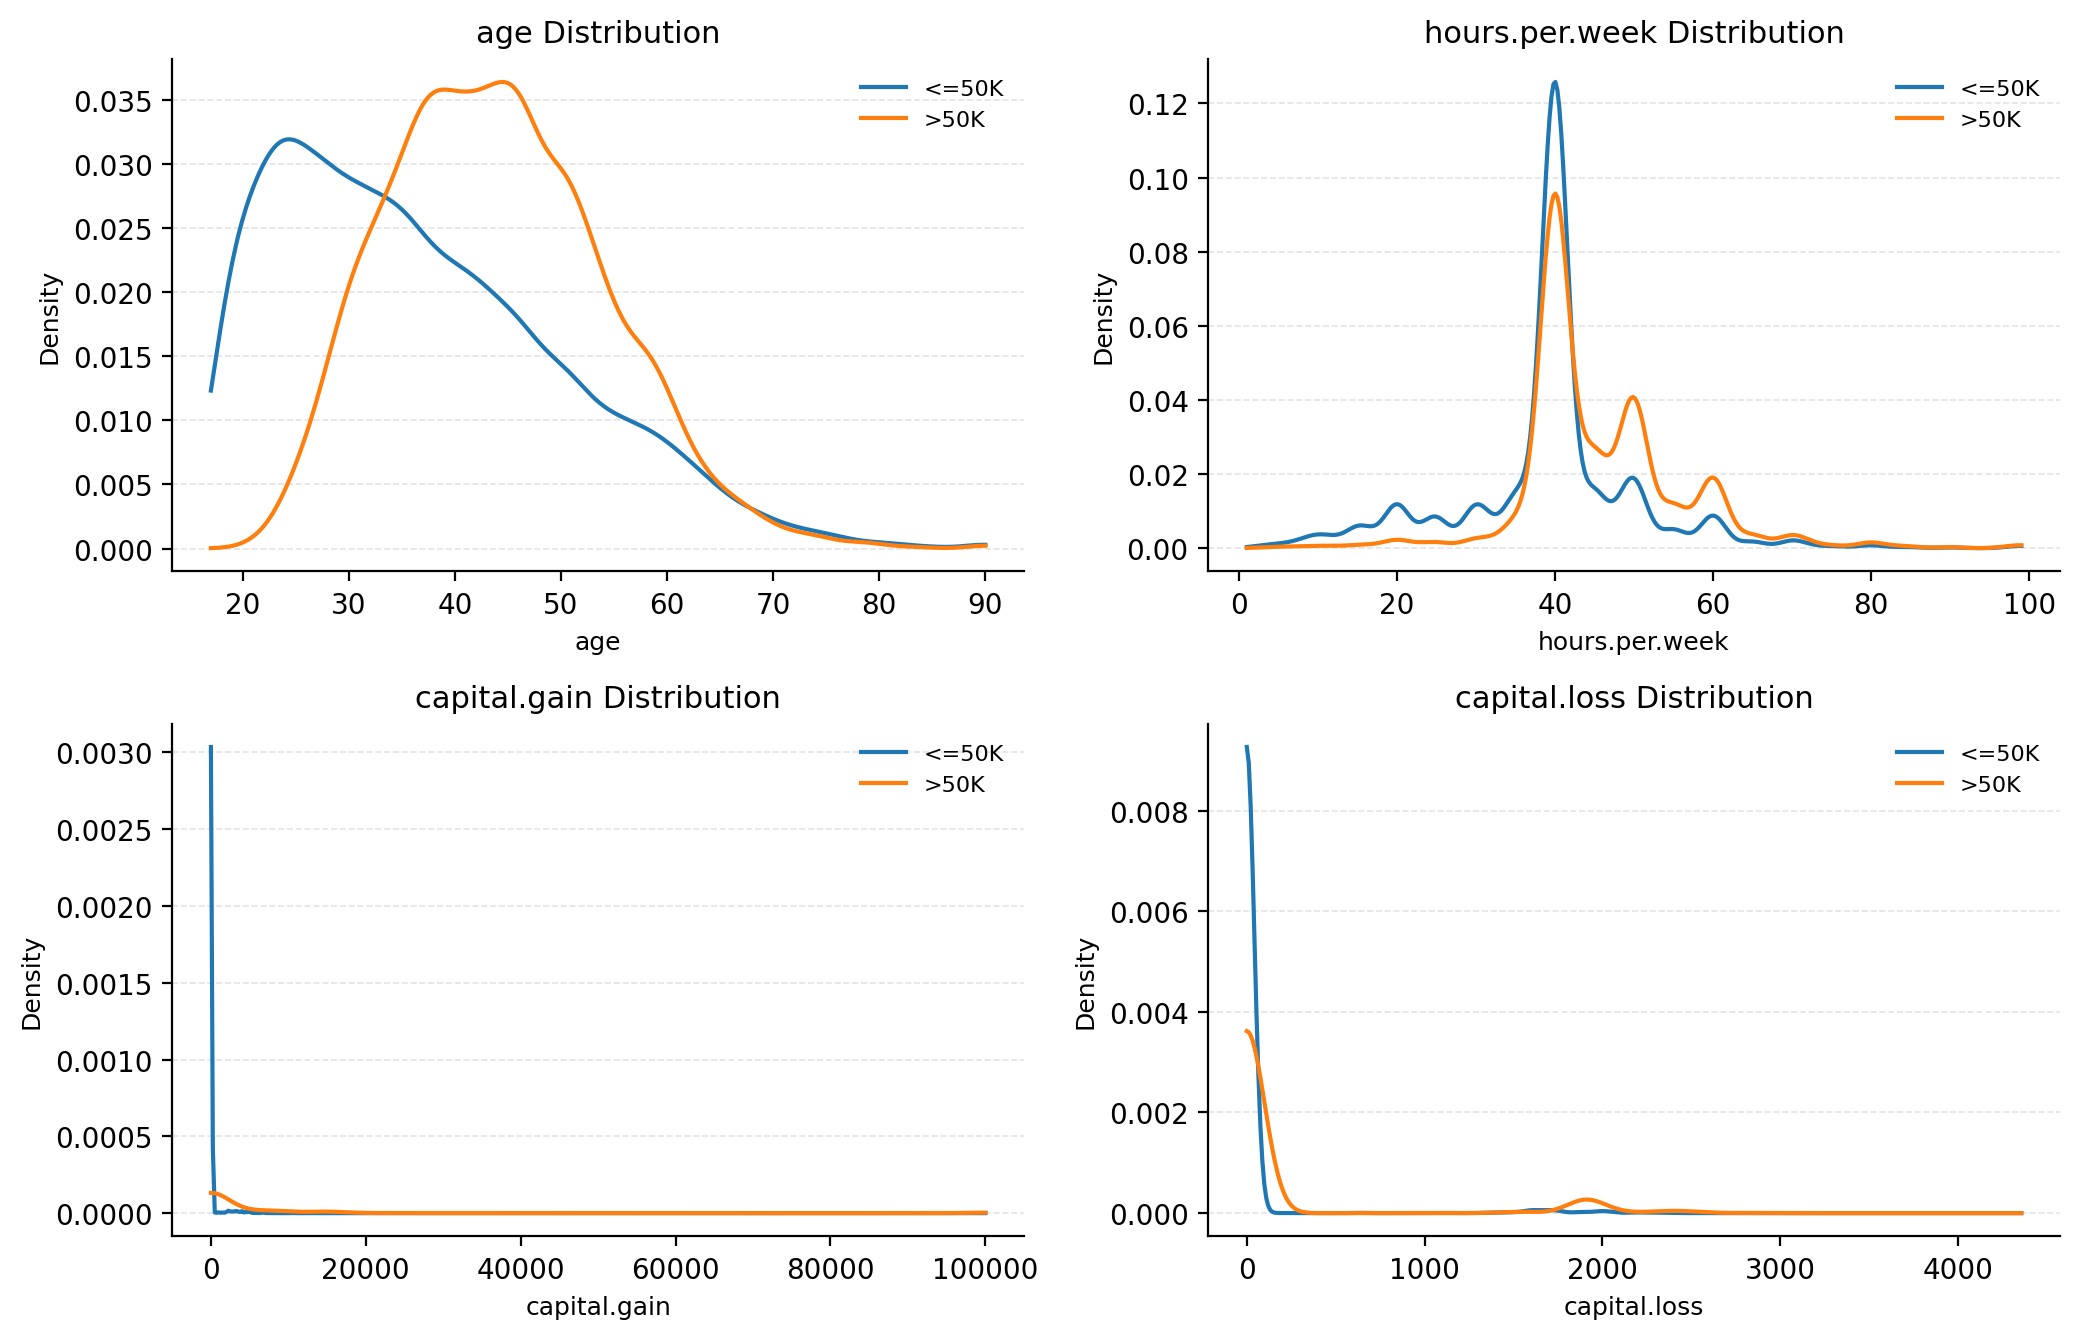

In [11]:
num_cols_eda = ["age", "hours.per.week", "capital.gain", "capital.loss"]
df_num = df[num_cols_eda + ["income"]].copy()
df_num["income_bin"] = df_num["income"].map({">50K": 1, "<=50K": 0})

fig, axes = plt.subplots(2, 2, figsize=(10.5, 6.8), dpi=200)
axes = axes.ravel()

for ax, c in zip(axes, num_cols_eda):
    v0 = df_num[df_num["income_bin"] == 0][c].dropna().to_numpy()
    v1 = df_num[df_num["income_bin"] == 1][c].dropna().to_numpy()
    xmin = min(v0.min(), v1.min())
    xmax = max(v0.max(), v1.max())
    xs = np.linspace(xmin, xmax, 400)
    kde0 = gaussian_kde(v0)
    kde1 = gaussian_kde(v1)
    ax.plot(xs, kde0(xs), label="<=50K")
    ax.plot(xs, kde1(xs), label=">50K")
    ax.set_title(f"{c} Distribution", fontsize=11, pad=6)
    ax.set_xlabel(c, fontsize=9)
    ax.set_ylabel("Density", fontsize=9)
    ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.35)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
cat_feature = "education"
ct = pd.crosstab(df[cat_feature], df["income"], normalize="index")
ct = ct.sort_values(by=">50K", ascending=False)
ct_top = ct.head(10)
ct_top

income,<=50K,>50K
education,,
Prof-school,0.250923,0.749077
Doctorate,0.253333,0.746667
Masters,0.435771,0.564229
Bachelors,0.578509,0.421491
Assoc-voc,0.736802,0.263198
Assoc-acdm,0.746032,0.253968
Some-college,0.799940,0.200060
HS-grad,0.835671,0.164329
12th,0.923077,0.076923


In [13]:
labels = ct_top.index.astype(str)
low = ct_top["<=50K"].values
high = ct_top[">50K"].values
labels[:5], low[:5], high[:5]

(Index(['Prof-school', 'Doctorate', 'Masters', 'Bachelors', 'Assoc-voc'], dtype='object', name='education'),
 array([0.25092251, 0.25333333, 0.43577136, 0.57850912, 0.73680184]),
 array([0.74907749, 0.74666667, 0.56422864, 0.42149088, 0.26319816]))

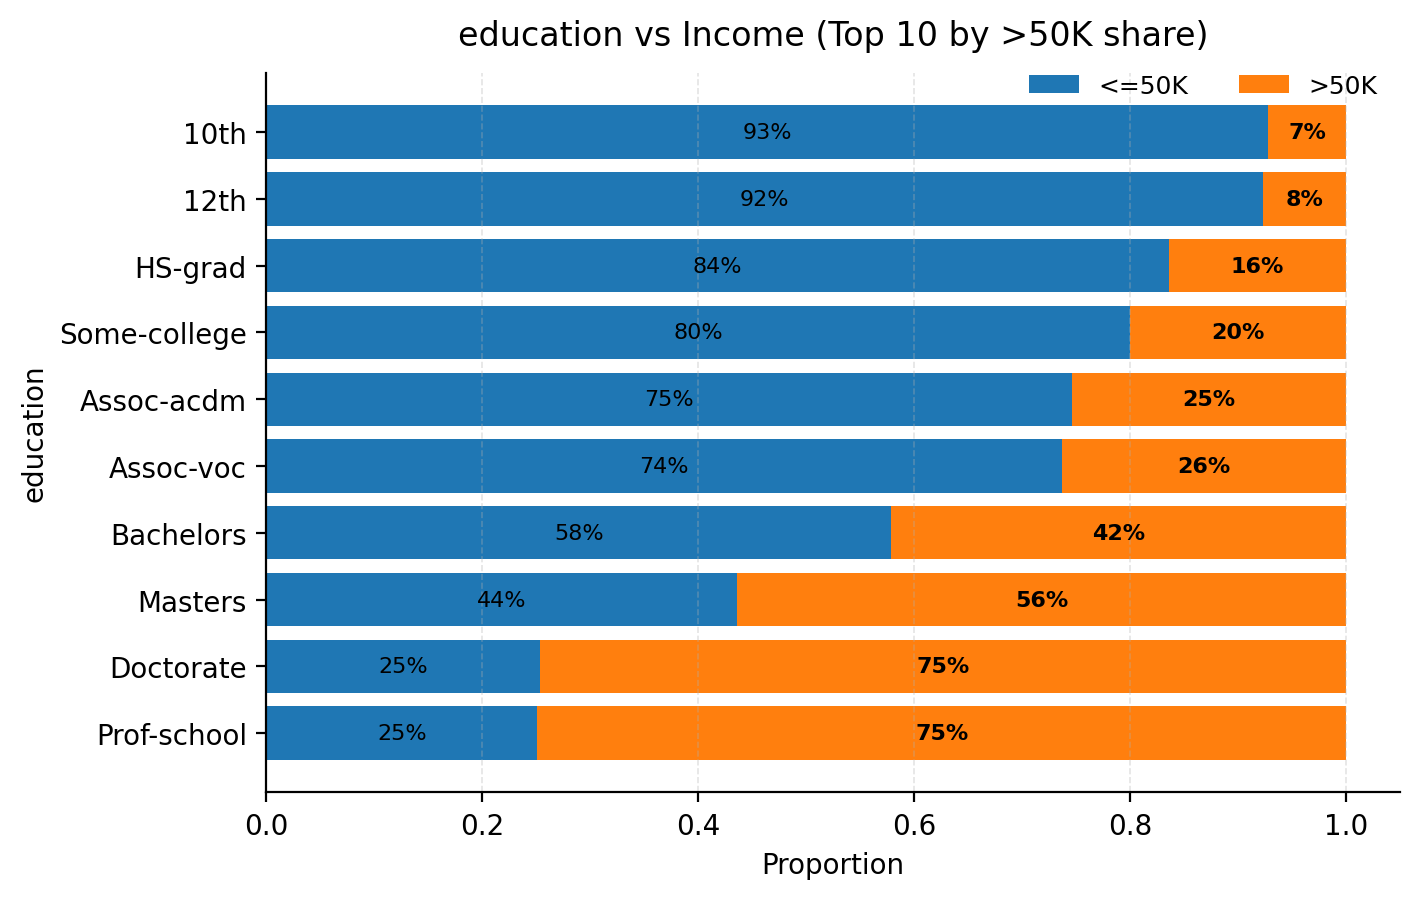

In [14]:
plt.figure(figsize=(7.2, 4.6), dpi=200)
ax = plt.gca()

ax.barh(labels, low, label="<=50K")
ax.barh(labels, high, left=low, label=">50K")

ax.set_title(f"{cat_feature} vs Income (Top 10 by >50K share)", fontsize=12, pad=10)
ax.set_xlabel("Proportion", fontsize=10)
ax.set_ylabel(cat_feature, fontsize=10)
ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for i, (l, h) in enumerate(zip(low, high)):
    ax.text(l/2, i, f"{l:.0%}", va="center", ha="center", fontsize=8)
    ax.text(l + h/2, i, f"{h:.0%}", va="center", ha="center", fontsize=8, weight="bold")

ax.legend(frameon=False, fontsize=9, loc="upper right", bbox_to_anchor=(1, 1.03), ncol=2)
plt.tight_layout()
plt.show()

## 4. Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((800, 14), (200, 14))

In [16]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(income
 0    0.75125
 1    0.24875
 Name: proportion, dtype: float64,
 income
 0    0.75
 1    0.25
 Name: proportion, dtype: float64)

## 5. Binarize

In [17]:
num_cols = ["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", "hours.per.week"]
cat_cols = [c for c in X_train.columns if c not in num_cols]
num_cols, cat_cols

(['age',
  'fnlwgt',
  'education.num',
  'capital.gain',
  'capital.loss',
  'hours.per.week'],
 ['workclass',
  'education',
  'marital.status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native.country'])

In [18]:
X_all = pd.concat([X_train, X_test], axis=0)
X_num_binned = X_all[num_cols].apply(lambda s: pd.qcut(s, q=4, duplicates="drop"))
X_num_binned.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
24411,"(16.999, 27.0]","(177657.0, 232912.5]","(9.0, 10.0]","(-0.001, 99999.0]","(-0.001, 2444.0]","(0.999, 40.0]"
27928,"(27.0, 36.5]","(232912.5, 1033222.0]","(0.999, 9.0]","(-0.001, 99999.0]","(-0.001, 2444.0]","(0.999, 40.0]"
31703,"(27.0, 36.5]","(232912.5, 1033222.0]","(10.0, 13.0]","(-0.001, 99999.0]","(-0.001, 2444.0]","(48.0, 99.0]"
30233,"(27.0, 36.5]","(232912.5, 1033222.0]","(10.0, 13.0]","(-0.001, 99999.0]","(-0.001, 2444.0]","(40.0, 48.0]"
6940,"(16.999, 27.0]","(177657.0, 232912.5]","(0.999, 9.0]","(-0.001, 99999.0]","(-0.001, 2444.0]","(48.0, 99.0]"


In [19]:
X_num_oh = pd.get_dummies(X_num_binned, prefix_sep="=")
X_num_oh.shape

(1000, 17)

In [20]:
X_cat_oh = pd.get_dummies(X_all[cat_cols], prefix_sep="=")
X_cat_oh.shape

(1000, 85)

In [21]:
X_all_oh = pd.concat([X_num_oh, X_cat_oh], axis=1).astype(int)
X_all_oh.shape

(1000, 102)

In [22]:
X_train_oh = X_all_oh.iloc[:len(X_train)]
X_test_oh = X_all_oh.iloc[len(X_train):]

X_train_oh.shape, X_test_oh.shape

((800, 102), (200, 102))

In [23]:
X_all_oh.columns[:20]

Index(['age=(16.999, 27.0]', 'age=(27.0, 36.5]', 'age=(36.5, 46.25]',
       'age=(46.25, 81.0]', 'fnlwgt=(20533.999, 114074.25]',
       'fnlwgt=(114074.25, 177657.0]', 'fnlwgt=(177657.0, 232912.5]',
       'fnlwgt=(232912.5, 1033222.0]', 'education.num=(0.999, 9.0]',
       'education.num=(9.0, 10.0]', 'education.num=(10.0, 13.0]',
       'education.num=(13.0, 16.0]', 'capital.gain=(-0.001, 99999.0]',
       'capital.loss=(-0.001, 2444.0]', 'hours.per.week=(0.999, 40.0]',
       'hours.per.week=(40.0, 48.0]', 'hours.per.week=(48.0, 99.0]',
       'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private'],
      dtype='object')

## 6. Lazy FCA & Improvement

In [24]:
train_attrs = [set(X_train_oh.columns[row.astype(bool)]) for _, row in X_train_oh.iterrows()]
test_attrs = [set(X_test_oh.columns[row.astype(bool)]) for _, row in X_test_oh.iterrows()]
len(train_attrs), len(test_attrs)

(800, 200)

In [25]:
pos_train_attrs = [a for a, label in zip(train_attrs, y_train.tolist()) if label == 1]
neg_train_attrs = [a for a, label in zip(train_attrs, y_train.tolist()) if label == 0]
len(pos_train_attrs), len(neg_train_attrs)

(199, 601)

In [26]:
list(pos_train_attrs[0])[:15]

['capital.loss=(-0.001, 2444.0]',
 'occupation=Prof-specialty',
 'race=White',
 'education=Bachelors',
 'capital.gain=(-0.001, 99999.0]',
 'sex=Female',
 'marital.status=Married-civ-spouse',
 'native.country=United-States',
 'fnlwgt=(232912.5, 1033222.0]',
 'hours.per.week=(48.0, 99.0]',
 'workclass=Private',
 'relationship=Wife',
 'education.num=(10.0, 13.0]',
 'age=(27.0, 36.5]']

In [27]:
def lazy_fca_predict_one(g_attrs, pos_context, neg_context, x=0, min_cardinality=1):
    pos_good = 0
    neg_good = 0
    
    for a_pos in pos_context:
        inter = a_pos & g_attrs
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_neg in neg_context if inter.issubset(a_neg))
            if ce <= x:
                pos_good += 1

    for a_neg in neg_context:
        inter = a_neg & g_attrs
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_pos in pos_context if inter.issubset(a_pos))
            if ce <= x:
                neg_good += 1

    return 1 if pos_good >= neg_good else 0

In [28]:
pred_test = [lazy_fca_predict_one(g, pos_train_attrs, neg_train_attrs, x=0, min_cardinality=2) for g in test_attrs]
pred_test[:20]

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [29]:
print("F1:", f1_score(y_test, pred_test))
print("Accuracy:", accuracy_score(y_test, pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=4))

F1: 0.43037974683544306
Accuracy: 0.775
Confusion matrix:
 [[138  12]
 [ 33  17]]
              precision    recall  f1-score   support

           0     0.8070    0.9200    0.8598       150
           1     0.5862    0.3400    0.4304        50

    accuracy                         0.7750       200
   macro avg     0.6966    0.6300    0.6451       200
weighted avg     0.7518    0.7750    0.7525       200



In [30]:
def lazy_fca_predict_one_v2(g_attrs, pos_context, neg_context, x=0, min_cardinality=1, tau=0.6):
    pos_good = 0
    neg_good = 0
    
    for a_pos in pos_context:
        inter = a_pos & g_attrs
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_neg in neg_context if inter.issubset(a_neg))
            if ce <= x:
                pos_good += 1

    for a_neg in neg_context:
        inter = a_neg & g_attrs
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_pos in pos_context if inter.issubset(a_pos))
            if ce <= x:
                neg_good += 1

    total = pos_good + neg_good
    if total == 0:
        return 0
    return 1 if pos_good / total >= tau else 0

In [31]:
xs = [0, 1, 2, 5, 10]
mins = [1, 2, 3]

In [32]:
results = []
for x_val in xs:
    for m_val in mins:
        preds = [lazy_fca_predict_one(g, pos_train_attrs, neg_train_attrs, x=x_val, min_cardinality=m_val) for g in test_attrs]
        results.append((x_val, m_val, f1_score(y_test, preds), accuracy_score(y_test, preds), confusion_matrix(y_test, preds)))

res_df = pd.DataFrame([(xv, mv, f1, acc) for xv, mv, f1, acc, _ in results], columns=["x", "min_cardinality", "f1", "accuracy"]).sort_values(["f1", "accuracy"], ascending=False)
res_df

,x,min_cardinality,f1,accuracy
6,2,1,0.485714,0.820
7,2,2,0.485714,0.820
8,2,3,0.485714,0.820
3,1,1,0.450704,0.805
4,1,2,0.450704,0.805
5,1,3,0.450704,0.805
9,5,1,0.437500,0.820
10,5,2,0.437500,0.820
11,5,3,0.437500,0.820
0,0,1,0.430380,0.775


In [33]:
results

[(0,
  1,
  0.43037974683544306,
  0.775,
  array([[138,  12],
         [ 33,  17]])),
 (0,
  2,
  0.43037974683544306,
  0.775,
  array([[138,  12],
         [ 33,  17]])),
 (0,
  3,
  0.43037974683544306,
  0.775,
  array([[138,  12],
         [ 33,  17]])),
 (1,
  1,
  0.4507042253521127,
  0.805,
  array([[145,   5],
         [ 34,  16]])),
 (1,
  2,
  0.4507042253521127,
  0.805,
  array([[145,   5],
         [ 34,  16]])),
 (1,
  3,
  0.4507042253521127,
  0.805,
  array([[145,   5],
         [ 34,  16]])),
 (2,
  1,
  0.4857142857142857,
  0.82,
  array([[147,   3],
         [ 33,  17]])),
 (2,
  2,
  0.4857142857142857,
  0.82,
  array([[147,   3],
         [ 33,  17]])),
 (2,
  3,
  0.4857142857142857,
  0.82,
  array([[147,   3],
         [ 33,  17]])),
 (5,
  1,
  0.4375,
  0.82,
  array([[150,   0],
         [ 36,  14]])),
 (5,
  2,
  0.4375,
  0.82,
  array([[150,   0],
         [ 36,  14]])),
 (5,
  3,
  0.4375,
  0.82,
  array([[150,   0],
         [ 36,  14]])),
 (10,
 

In [34]:
best_x = 2
best_m = 1
taus = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

In [35]:
tau_results = []
for t in taus:
    preds = [lazy_fca_predict_one_v2(g, pos_train_attrs, neg_train_attrs, x=best_x, min_cardinality=best_m, tau=t) for g in test_attrs]
    tau_results.append((t, f1_score(y_test, preds), accuracy_score(y_test, preds), confusion_matrix(y_test, preds)))

tau_df = pd.DataFrame([(t, f1, acc) for t, f1, acc, _ in tau_results], columns=["tau", "f1", "accuracy"]).sort_values(["f1", "accuracy"], ascending=False)
tau_df

,tau,f1,accuracy
0,0.40,0.533333,0.825
1,0.45,0.527778,0.830
2,0.50,0.485714,0.820
3,0.55,0.447761,0.815
4,0.60,0.375000,0.800
5,0.65,0.327869,0.795


In [36]:
tau_results

[(0.4,
  0.5333333333333333,
  0.825,
  array([[145,   5],
         [ 30,  20]])),
 (0.45,
  0.5277777777777778,
  0.83,
  array([[147,   3],
         [ 31,  19]])),
 (0.5,
  0.4857142857142857,
  0.82,
  array([[147,   3],
         [ 33,  17]])),
 (0.55,
  0.44776119402985076,
  0.815,
  array([[148,   2],
         [ 35,  15]])),
 (0.6,
  0.375,
  0.8,
  array([[148,   2],
         [ 38,  12]])),
 (0.65,
  0.32786885245901637,
  0.795,
  array([[149,   1],
         [ 40,  10]]))]

In [37]:
best_tau = 0.4
pred_best = [lazy_fca_predict_one_v2(g, pos_train_attrs, neg_train_attrs, x=best_x, min_cardinality=best_m, tau=best_tau) for g in test_attrs]

In [38]:
print("F1:", f1_score(y_test, pred_best))
print("Accuracy:", accuracy_score(y_test, pred_best))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_best))
print(classification_report(y_test, pred_best, digits=4))

F1: 0.5333333333333333
Accuracy: 0.825
Confusion matrix:
 [[145   5]
 [ 30  20]]
              precision    recall  f1-score   support

           0     0.8286    0.9667    0.8923       150
           1     0.8000    0.4000    0.5333        50

    accuracy                         0.8250       200
   macro avg     0.8143    0.6833    0.7128       200
weighted avg     0.8214    0.8250    0.8026       200



In [39]:
def lazy_fca_predict_one_topk_v2(g_attrs, pos_context, neg_context, x=2, min_cardinality=1, tau=0.4, k=80):
    pos_inters = sorted((a_pos & g_attrs for a_pos in pos_context), key=len, reverse=True)[:k]
    neg_inters = sorted((a_neg & g_attrs for a_neg in neg_context), key=len, reverse=True)[:k]

    pos_good = 0
    neg_good = 0

    for inter in pos_inters:
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_neg in neg_context if inter.issubset(a_neg))
            if ce <= x:
                pos_good += 1

    for inter in neg_inters:
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_pos in pos_context if inter.issubset(a_pos))
            if ce <= x:
                neg_good += 1

    total = pos_good + neg_good
    if total == 0:
        return 0
    return 1 if pos_good / total >= tau else 0

In [40]:
ks = [10, 20, 30, 50, 80, 120, 160, 220]

In [41]:
topk_results = []
for k_val in ks:
    preds = [lazy_fca_predict_one_topk_v2(g, pos_train_attrs, neg_train_attrs, x=2, min_cardinality=1, tau=0.4, k=k_val) for g in test_attrs]
    topk_results.append((k_val, f1_score(y_test, preds), accuracy_score(y_test, preds), confusion_matrix(y_test, preds)))

topk_df = pd.DataFrame([(k, f1, acc) for k, f1, acc, _ in topk_results], columns=["k", "f1", "accuracy"]).sort_values(["f1", "accuracy"], ascending=False)
topk_df

,k,f1,accuracy
2,30,0.627451,0.810
1,20,0.614035,0.780
4,80,0.606742,0.825
3,50,0.589474,0.805
5,120,0.588235,0.825
0,10,0.567376,0.695
7,220,0.556962,0.825
6,160,0.543210,0.815


In [42]:
topk_results

[(10,
  0.5673758865248227,
  0.695,
  array([[99, 51],
         [10, 40]])),
 (20,
  0.6140350877192983,
  0.78,
  array([[121,  29],
         [ 15,  35]])),
 (30,
  0.6274509803921569,
  0.81,
  array([[130,  20],
         [ 18,  32]])),
 (50,
  0.5894736842105263,
  0.805,
  array([[133,  17],
         [ 22,  28]])),
 (80,
  0.6067415730337079,
  0.825,
  array([[138,  12],
         [ 23,  27]])),
 (120,
  0.5882352941176471,
  0.825,
  array([[140,  10],
         [ 25,  25]])),
 (160,
  0.5432098765432098,
  0.815,
  array([[141,   9],
         [ 28,  22]])),
 (220,
  0.5569620253164557,
  0.825,
  array([[143,   7],
         [ 28,  22]]))]

In [43]:
best_k = 30
pred_topk_best = [lazy_fca_predict_one_topk_v2(g, pos_train_attrs, neg_train_attrs, x=2, min_cardinality=1, tau=0.4, k=best_k) for g in test_attrs]

In [44]:
print("F1:", f1_score(y_test, pred_topk_best))
print("Accuracy:", accuracy_score(y_test, pred_topk_best))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_topk_best))
print(classification_report(y_test, pred_topk_best, digits=4))

F1: 0.6274509803921569
Accuracy: 0.81
Confusion matrix:
 [[130  20]
 [ 18  32]]
              precision    recall  f1-score   support

           0     0.8784    0.8667    0.8725       150
           1     0.6154    0.6400    0.6275        50

    accuracy                         0.8100       200
   macro avg     0.7469    0.7533    0.7500       200
weighted avg     0.8126    0.8100    0.8112       200



## 7. Evidence Cases

In [45]:
def lazy_fca_predict_with_evidence_topk(g_attrs, pos_context, neg_context, x=2, min_cardinality=1, tau=0.4, k=30):
    pos_inters = sorted((a_pos & g_attrs for a_pos in pos_context), key=len, reverse=True)[:k]
    neg_inters = sorted((a_neg & g_attrs for a_neg in neg_context), key=len, reverse=True)[:k]

    pos_evidence = []
    neg_evidence = []

    for inter in pos_inters:
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_neg in neg_context if inter.issubset(a_neg))
            if ce <= x:
                pos_evidence.append(inter)

    for inter in neg_inters:
        if len(inter) >= min_cardinality:
            ce = sum(1 for a_pos in pos_context if inter.issubset(a_pos))
            if ce <= x:
                neg_evidence.append(inter)

    total = len(pos_evidence) + len(neg_evidence)
    if total == 0:
        return 0, pos_evidence, neg_evidence
    pred = 1 if len(pos_evidence) / total >= tau else 0
    return pred, pos_evidence, neg_evidence

In [46]:
preds_with_ev = [lazy_fca_predict_with_evidence_topk(g, pos_train_attrs, neg_train_attrs, x=2, min_cardinality=1, tau=0.4, k=30) for g in test_attrs]
pred_labels = [p for p, _, _ in preds_with_ev]
true_labels = y_test.tolist()

In [47]:
tp_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == 1 and p == 1]
tn_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == 0 and p == 0]
fp_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == 0 and p == 1]
fn_idx = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t == 1 and p == 0]

picked = []
for name, idxs in [("TP", tp_idx), ("TN", tn_idx), ("FP", fp_idx), ("FN", fn_idx)]:
    if len(idxs) > 0:
        picked.append((name, idxs[0]))

rows = []
for kind, i in picked:
    pred_i, pos_ev, neg_ev = preds_with_ev[i]
    pos_top = sorted(pos_ev, key=len, reverse=True)[:3]
    neg_top = sorted(neg_ev, key=len, reverse=True)[:3]
    rows.append({
        "type": kind,
        "index_in_test": i,
        "true": true_labels[i],
        "pred": pred_i,
        "pos_good": len(pos_ev),
        "neg_good": len(neg_ev),
        "top_pos_evidence": pos_top,
        "top_neg_evidence": neg_top
    })

evidence_df = pd.DataFrame(rows)
evidence_df

,type,index_in_test,true,pred,pos_good,neg_good,top_pos_evidence,top_neg_evidence
0,TP,1,1,1,19,13,"[{capital.loss=(-0.001, 2444.0], workclass=Sel...","[{capital.loss=(-0.001, 2444.0], workclass=Sel..."
1,TN,4,0,0,0,30,[],"[{hours.per.week=(0.999, 40.0], capital.loss=(..."
2,FP,0,0,1,26,30,"[{capital.loss=(-0.001, 2444.0], workclass=Sel...","[{capital.loss=(-0.001, 2444.0], race=White, r..."
3,FN,3,1,0,13,27,"[{hours.per.week=(0.999, 40.0], capital.loss=(...","[{hours.per.week=(0.999, 40.0], capital.loss=(..."


## 8. Speedup

In [48]:
baseline_fn = lambda g: lazy_fca_predict_one_v2(g, pos_train_attrs, neg_train_attrs, x=2, min_cardinality=1, tau=0.4)
topk_fn = lambda g: lazy_fca_predict_one_topk_v2(g, pos_train_attrs, neg_train_attrs, x=2, min_cardinality=1, tau=0.4, k=30)

In [49]:
t0 = time.perf_counter()
pred_base = [baseline_fn(g) for g in test_attrs]
t1 = time.perf_counter()

t2 = time.perf_counter()
pred_topk = [topk_fn(g) for g in test_attrs]
t3 = time.perf_counter()

avg_base = (t1 - t0) / len(test_attrs)
avg_topk = (t3 - t2) / len(test_attrs)

avg_base, avg_topk, avg_base / avg_topk

(0.021072781500006386, 0.0022297139999864156, 9.450889889974576)

In [50]:
print("baseline f1:", f1_score(y_test, pred_base), "acc:", accuracy_score(y_test, pred_base), "avg_time_per_sample:", avg_base)
print("topk30 f1:", f1_score(y_test, pred_topk), "acc:", accuracy_score(y_test, pred_topk), "avg_time_per_sample:", avg_topk)
print("speedup:", avg_base / avg_topk)

baseline f1: 0.5333333333333333 acc: 0.825 avg_time_per_sample: 0.021072781500006386
topk30 f1: 0.6274509803921569 acc: 0.81 avg_time_per_sample: 0.0022297139999864156
speedup: 9.450889889974576


## 9. Compare Models

In [66]:
param_grids = {
    "LogReg": {
        "model__C": [0.01, 0.1, 1, 3, 10, 30],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"]
    },
    "SVM_rbf": {
        "model__C": [0.1, 1, 3, 10, 30],
        "model__gamma": ["scale", 0.01, 0.03, 0.1, 0.3, 1]
    },
    "RF": {
        "model__n_estimators": [200, 400, 600],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_leaf": [1, 2, 5]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 15, 25],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    },
    "BernNB": {
        "model__alpha": [0.1, 0.5, 1.0, 2.0, 5.0]
    },
    "DT": {
        "model__max_depth": [None, 3, 5, 8, 12, 20],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__ccp_alpha": [0.0, 0.001, 0.01]
    }
}

In [67]:
results = []
best_models = {}

for name, model in models.items():
    clf = Pipeline([("prep", preprocess_ml), ("model", model)])
    search = GridSearchCV(clf, param_grids[name], scoring="f1", cv=5, n_jobs=1)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    preds = search.best_estimator_.predict(X_test)
    results.append((name, search.best_params_, f1_score(y_test, preds), accuracy_score(y_test, preds)))

In [68]:
score_df = pd.DataFrame(results, columns=["model", "best_params", "f1", "accuracy"]).sort_values(["f1","accuracy"], ascending=False)
score_df

,model,best_params,f1,accuracy
0,LogReg,"{'model__C': 3, 'model__penalty': 'l2', 'model...",0.666667,0.850
1,SVM_rbf,"{'model__C': 30, 'model__gamma': 0.01}",0.651685,0.845
4,BernNB,{'model__alpha': 0.1},0.612613,0.785
2,RF,"{'model__max_depth': 10, 'model__min_samples_l...",0.592593,0.835
3,KNN,"{'model__n_neighbors': 7, 'model__p': 2, 'mode...",0.545455,0.800
5,DT,"{'model__ccp_alpha': 0.001, 'model__max_depth'...",0.525000,0.810


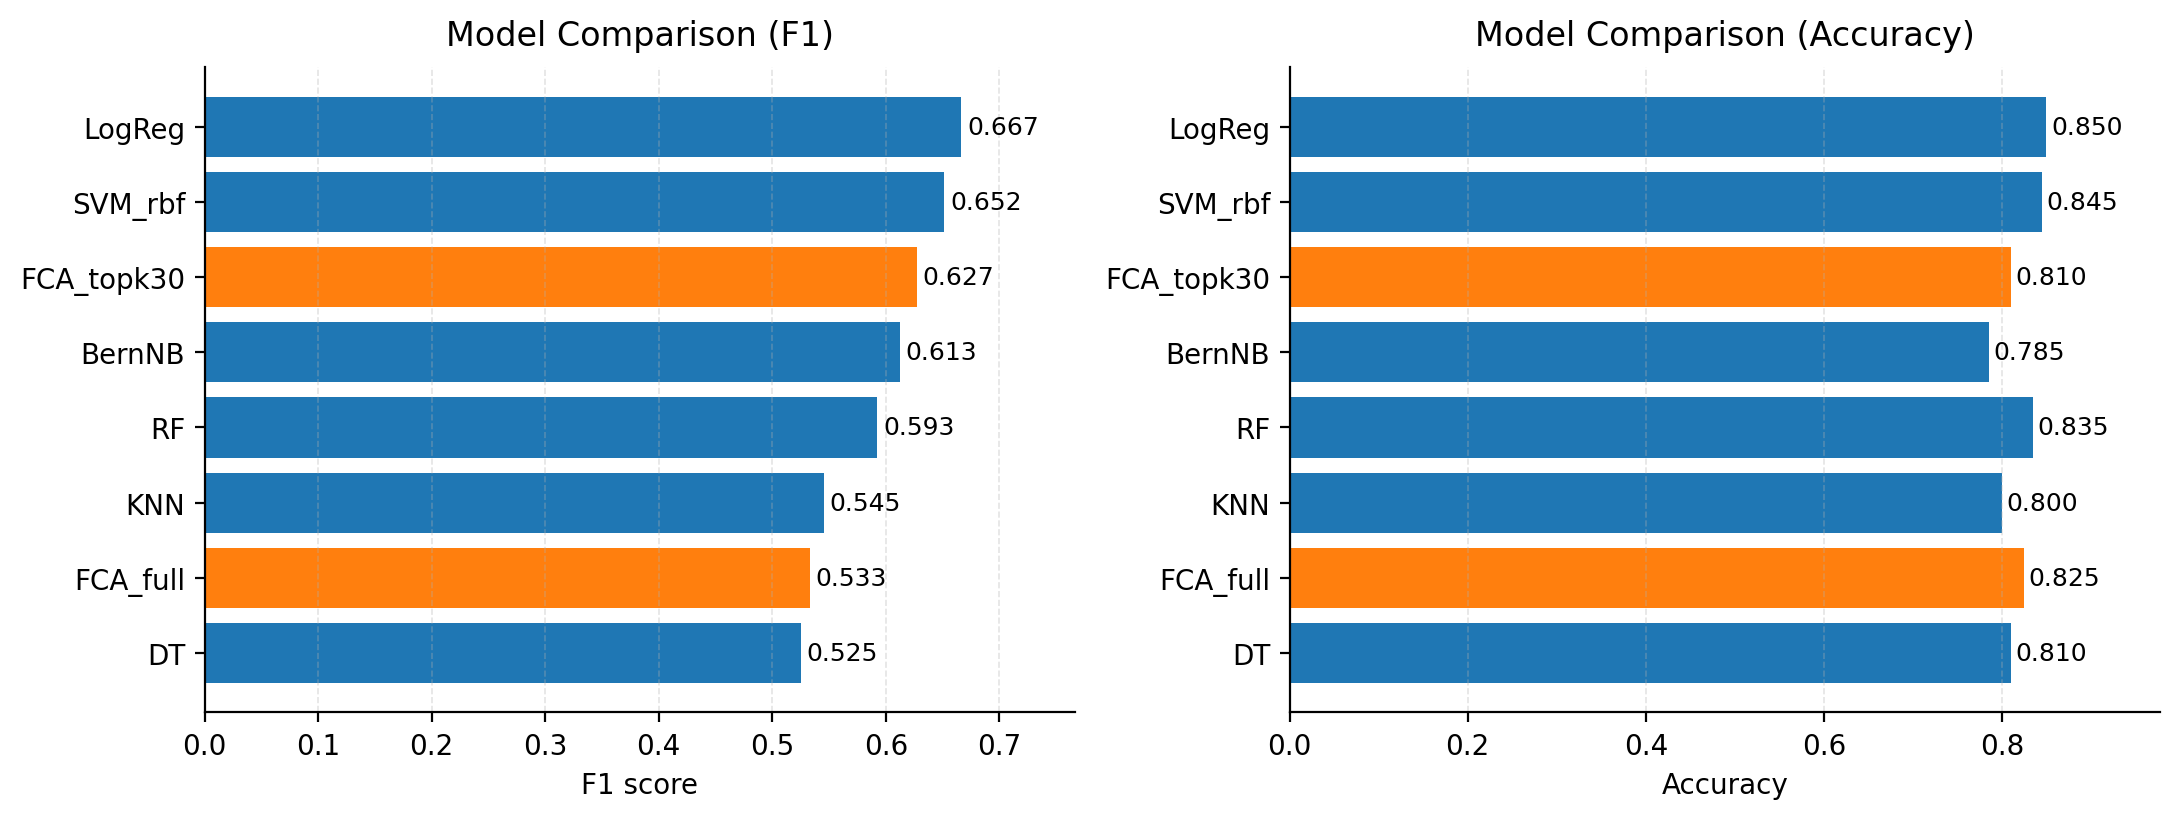

In [69]:
fca_rows = pd.DataFrame([
    ["FCA_full", f1_score(y_test, pred_best), accuracy_score(y_test, pred_best)],
    ["FCA_topk30", f1_score(y_test, pred_topk_best), accuracy_score(y_test, pred_topk_best)]
], columns=["model", "f1", "accuracy"])

cmp_df = pd.concat([score_df, fca_rows], ignore_index=True).sort_values("f1", ascending=True)

labels = cmp_df["model"].astype(str)
f1_vals = cmp_df["f1"].values
acc_vals = cmp_df["accuracy"].values
colors = ["tab:orange" if "FCA" in m else "tab:blue" for m in labels]

fig, axes = plt.subplots(1, 2, figsize=(11.0, 4.2), dpi=200)

ax = axes[0]
bars = ax.barh(labels, f1_vals, color=colors)
ax.set_title("Model Comparison (F1)", fontsize=12, pad=8)
ax.set_xlabel("F1 score", fontsize=10)
ax.set_ylabel("")
ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for b, v in zip(bars, f1_vals):
    ax.text(v + 0.005, b.get_y() + b.get_height()/2, f"{v:.3f}", va="center", fontsize=9)
ax.set_xlim(0, max(f1_vals) * 1.15)

ax = axes[1]
bars = ax.barh(labels, acc_vals, color=colors)
ax.set_title("Model Comparison (Accuracy)", fontsize=12, pad=8)
ax.set_xlabel("Accuracy", fontsize=10)
ax.set_ylabel("")
ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for b, v in zip(bars, acc_vals):
    ax.text(v + 0.005, b.get_y() + b.get_height()/2, f"{v:.3f}", va="center", fontsize=9)
ax.set_xlim(0, max(acc_vals) * 1.15)

plt.tight_layout()
plt.show()